In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize    
import numpy as np
from flatten_json import flatten
import itertools
from pprint import pprint  as pprint
github_json_file = "repos_top_recent_languages-20180906-194944.json"

In [2]:
with open(github_json_file) as data_file:    
    data = json.load(data_file)  

In [3]:
df1 = json_normalize(data, 'LANGUAGE', ['repo_name','watch_count'], 
                    record_prefix='language_')

In [4]:
df1.shape

(49315, 4)

In [5]:
#Drop if language is < 500 bytes
df1["language_bytes"] = df1["language_bytes"].map(int)

df1.dtypes
df1 = df1[df1["language_bytes"] > 500]

In [6]:
df2 = pd.read_json(github_json_file)
df2.head()

,LANGUAGE,repo_name,watch_count
0,"[{'name': 'CSS', 'bytes': '190263'}, {'name': ...",FreeCodeCamp/FreeCodeCamp,90457
1,[],joshbuchea/HEAD,13125
2,"[{'name': 'Assembly', 'bytes': '1286'}, {'name...",tensorflow/tensorflow,10728
3,"[{'name': 'C', 'bytes': '5219'}, {'name': 'C++...",facebook/react,10458
4,[],loverajoel/jstips,9585


In [7]:
df3 = df2[df2.astype(str)["LANGUAGE"]=='[]'].drop(labels="LANGUAGE", axis='columns')
df3.head()

,repo_name,watch_count
1,joshbuchea/HEAD,13125
4,loverajoel/jstips,9585
7,caesar0301/awesome-public-datasets,8653
11,googlesamples/android-architecture,7713
46,johnpapa/angular-styleguide,4403


In [8]:
df3["language_name"] = "None"
df3["language_bytes"] = 0
cols = list(df1.columns.values)
df3 = df3[cols]
df3.head()

,language_bytes,language_name,repo_name,watch_count
1,0,None,joshbuchea/HEAD,13125
4,0,None,loverajoel/jstips,9585
7,0,None,caesar0301/awesome-public-datasets,8653
11,0,None,googlesamples/android-architecture,7713
46,0,None,johnpapa/angular-styleguide,4403


In [9]:
df1 = df1.append(df3, ignore_index=True)
df1.tail()

,language_bytes,language_name,repo_name,watch_count
45192,0,None,GalliumOS/galliumos-distro,47
45193,0,None,adwiv/android-fat-aar,46
45194,0,None,Medalink/laravel-blade,46
45195,0,None,wspl/mactype-hack,46
45196,0,None,mediachain/mediachain,46


In [10]:
df1.head()

,language_bytes,language_name,repo_name,watch_count
0,190263,CSS,FreeCodeCamp/FreeCodeCamp,90457
1,160430,HTML,FreeCodeCamp/FreeCodeCamp,90457
2,546299,JavaScript,FreeCodeCamp/FreeCodeCamp,90457
3,1286,Assembly,tensorflow/tensorflow,10728
4,9258,Batchfile,tensorflow/tensorflow,10728


In [11]:
# Create a dataframe with language_name and the total number of bytes written in that language
# sort it in descencing order of popularity
languages_group = df1.groupby("language_name")
language_df = languages_group["language_bytes"].sum().to_frame()
language_df["language_bytes"] = language_df["language_bytes"].map(int)
#language_df["language_bytes"] = pd.to_numeric(language_df["language_bytes"], errors='ignore')
language_df.head()

,language_bytes
language_name,
1C Enterprise,1050791
ABAP,9530
AMPL,3448
ANTLR,625954
API Blueprint,98519


In [12]:
language_df.loc["JavaScript"]

language_bytes    3426809176
Name: JavaScript, dtype: int64

In [13]:
# This gives the total number of languages in our dataset
language_df.dtypes

language_bytes    int64
dtype: object

In [14]:
# Create dataframe with language_name and the number of repositories using that language (repo_count),
# sort it in descencing order of popularity
language_df["repo_count"]= languages_group["repo_name"].count()
language_df = language_df.fillna(0)


In [15]:
# get top 20 popular languages by number of repositories
top_20_popular_languages_df = language_df.sort_values("repo_count", ascending=False).head(19)
top_20_popular_languages  = top_20_popular_languages_df.index.tolist()
top_20_popular_languages.append("Other")
top_20_popular_languages_index = {k:v for v,k in enumerate(top_20_popular_languages)}
type(top_20_popular_languages_df)

pandas.core.frame.DataFrame

In [16]:
top_20_byte_languages = language_df.sort_values("language_bytes", ascending=False).head(19).index.tolist()
top_20_byte_languages.append("Other")
top_20_byte_languages

['C',
 'C++',
 'JavaScript',
 'Java',
 'Python',
 'C#',
 'HTML',
 'Go',
 'PHP',
 'Objective-C',
 'Jupyter Notebook',
 'Ruby',
 'CSS',
 'TypeScript',
 'Scala',
 'Swift',
 'Assembly',
 'Shell',
 'Erlang',
 'Other']

In [17]:
other_repo_count = 0
def language_name_function(ip_language_list):
    global other_repo_count
    language_list = []
    other_flag = False
    for l in ip_language_list:
        if l in top_20_popular_languages:
            language_list.append(top_20_popular_languages_index[l])
        else:
            other_flag = True
    if other_flag:
        other_repo_count += 1
        language_list.append(top_20_popular_languages_index["Other"])
    return language_list


repo_languages = df1.groupby("repo_name")["language_name"].apply(language_name_function)
repo_languages.head()

repo_name
01org/appframework                             [3, 1, 0]
01org/corelibs-arduino101              [9, 10, 7, 2, 19]
01org/idlf                   [14, 9, 10, 16, 3, 0, 4, 2]
0k/shyaml                                         [4, 2]
0rpc/zerorpc-python                                  [4]
Name: language_name, dtype: object

In [18]:
# Figure out how many repos have only "Other" languuages
top_20_popular_languages_df= top_20_popular_languages_df.append(pd.DataFrame.from_dict({'Other':[0, other_repo_count]}, orient='index', columns=["language_bytes", "repo_count"]))
top_20_popular_languages_df

,language_bytes,repo_count
JavaScript,3426809176,6212
HTML,1104937803,4483
Shell,118775015,3809
CSS,319896282,3543
Python,1492052416,2891
Ruby,323286011,2549
Java,3336941414,2403
Makefile,57854730,1892
Objective-C,431840619,1814
C,3884178499,1509


In [19]:
repo_languages_matrix = [[0 for _ in top_20_popular_languages] for _ in top_20_popular_languages]


In [20]:
for  language_list in repo_languages:
    w = 1
    for i,j in itertools.combinations(language_list,2):
        #print(i,j)
        repo_languages_matrix[i][j] += w
        repo_languages_matrix[j][i] += w
for k, lang in enumerate(top_20_popular_languages_df.index):
    repo_languages_matrix[k][k] = top_20_popular_languages_df.loc[lang]["repo_count"]



In [21]:
with open("data_ip.js","w") as op_file:    
    op_file.write("repo_languages_matrix = ")
    op_file.write(str(repo_languages_matrix))

In [22]:
sum(repo_languages_matrix[1])

18996

In [23]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
%matplotlib inline
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [24]:
Z = linkage(repo_languages_matrix, 'ward')

In [25]:
c, coph_dists = cophenet(Z, pdist(repo_languages_matrix))
c

0.876178268809121

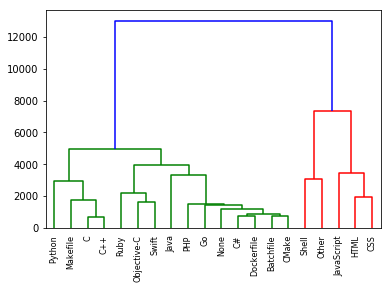

In [26]:
dend_data = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    leaf_label_func = lambda id:top_20_popular_languages[id]
)
plt.show()

In [27]:
dend_data["ivl"]

['Python',
 'Makefile',
 'C',
 'C++',
 'Ruby',
 'Objective-C',
 'Swift',
 'Java',
 'PHP',
 'Go',
 'None',
 'C#',
 'Dockerfile',
 'Batchfile',
 'CMake',
 'Shell',
 'Other',
 'JavaScript',
 'HTML',
 'CSS']

In [28]:
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly
plotly.tools.set_credentials_file(username='Sago', api_key='6PUqwPdLYUx2seHNmW2w')
import scipy.cluster.hierarchy as sch
import scipy.spatial as scs

In [29]:
fig = ff.create_dendrogram(np.asarray(repo_languages_matrix), labels=top_20_popular_languages, linkagefun=lambda x: sch.linkage(x, 'ward'))
fig['layout'].update({'width':800, 'height':800})
py.iplot(fig, filename="github_dendrogram", auto_open=True)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~Sago/0 or inside your plot.ly account where it is named 'github_dendrogram'


In [30]:
import seaborn as sns

In [31]:
repo_df = pd.DataFrame(repo_languages_matrix, index= top_20_popular_languages, columns = top_20_popular_languages)


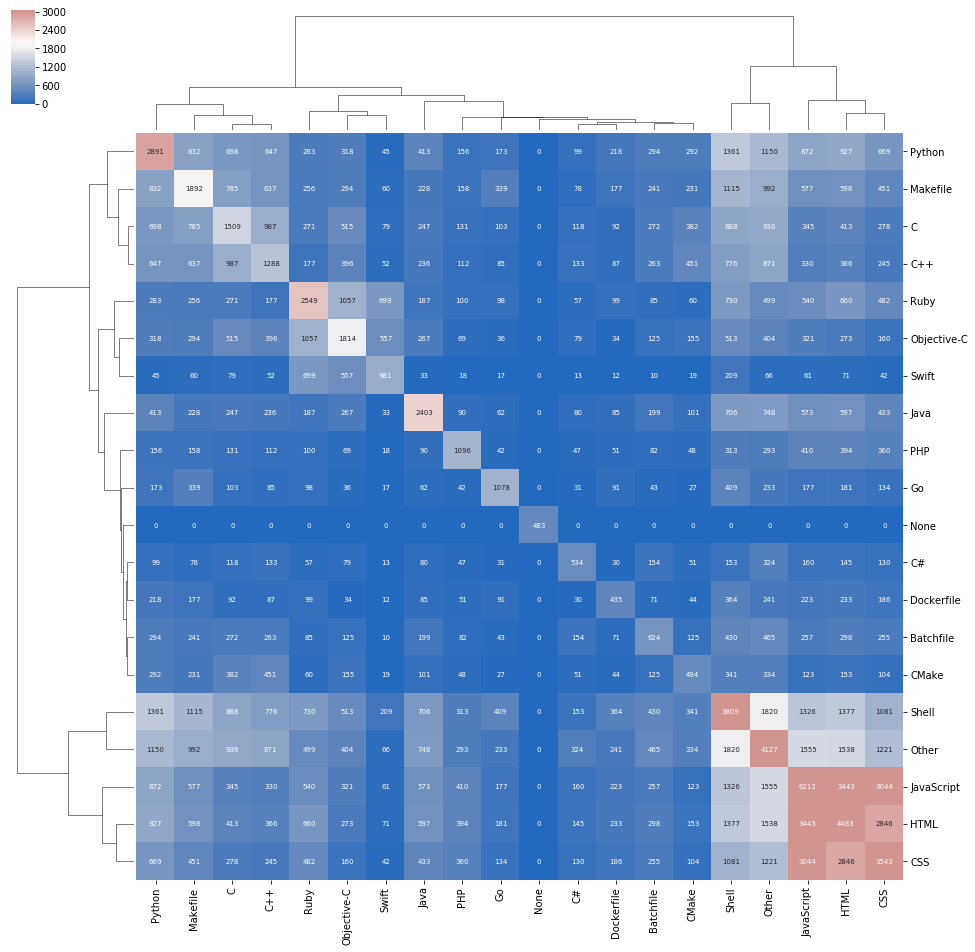

In [32]:
cg1 = sns.clustermap(repo_df, figsize=(16,16), method="ward", cmap="vlag", annot=True, fmt='d', annot_kws={'size':7}, robust=True, center=2000)


In [33]:
nodes = []
links = []
for i, lang in enumerate(top_20_popular_languages):
    for j, _ in enumerate(top_20_popular_languages):
        if int(repo_languages_matrix[i][j]) == 0:
            continue
        if i==j:
            nodes.append({"id":lang, "size": int(repo_languages_matrix[i][i])})
        elif i>j:
            links.append({"source":lang,"target":top_20_popular_languages[j], "value":int(repo_languages_matrix[i][j])})
graph = {"nodes":nodes, "links":links}
#pprint(graph)
    

In [34]:
with open("graph_ip.json","w") as op_file:  
    json.dump(graph, op_file, sort_keys=True, indent=4)
